Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

## 1.1. Откроем данные и посмотрим на общую картину

### Импортируем нужные библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import timeit
import time

In [2]:
warnings.filterwarnings('ignore') 
pd.options.display.max_columns = 16
%matplotlib inline

### Пропишем заранее функции для 1-го шага (DRY)

In [3]:
# Общее предстваление датасета:
def df_info(df):
    df.info()
    display(df.head())
    print('Кол-во пропусков в датасете:')
    print(df.isnull().sum())
    print()
    print(f'Кол-во дубликатов: {df.duplicated().sum()}')
    

# Распределение данных:
def df_value_counts(df, column):
    print(df[column].value_counts())
    print(f'Кол-во пропусков в столбце: {df[column].isnull().sum()}')
    
    
# График распределения:
def hist(df, column, title, bins):
    plt.figure(figsize=(12, 10))
    plt.title(title, fontsize=12)
    sns.distplot(df[column], bins=bins, kde=True)
    plt.grid(True)
    
    
def boxplot(df, column, title):
    plt.figure(figsize=(12, 10))
    sns.boxplot(data=df[column])
    plt.title(title, fontsize=12)
    plt.grid(True)
    plt.show()

In [4]:
autos = pd.read_csv('/datasets/autos.csv')

df_info(autos)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Кол-во пропусков в датасете:
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Кол-во дубликатов: 4


*В датасете присутствуют пропуски и дубликаты.*

*Возможно возникли проблемы при переносе данных, либо заполняющие не указали параметры*

*В следующем шаге удалим из датасета столбцы "DateCrawled", "RegistrationMonth", "DateCreated", "PostalCode", "LastSeen", так как данные столбцы могут повлиять на модели в ходе обучения*

## 1.2. Предобработка данных

Удалим дубликаты и столбцы, которые не влияют на ценообразование

In [5]:
# Уберем дубликаты из датасета:
autos = autos.drop_duplicates().reset_index(drop=True)

# Удалим столбцы: (Прежде чем удалять, нужно понять временный интервал создания анкет)
print('Ранняя и поздняя даты анкет:')
print('Min:', autos['DateCreated'].min())
print('Max:', autos['DateCreated'].max())
autos = autos.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'LastSeen', 'PostalCode'], axis = 1)

Ранняя и поздняя даты анкет:
Min: 2014-03-10 00:00:00
Max: 2016-04-07 00:00:00


### Анализ признаков

#### Price

In [6]:
autos['Price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13440        1
1414         1
8069         1
10370        1
384          1
Name: Price, Length: 3731, dtype: int64
Кол-во пропусков в столбце: 0


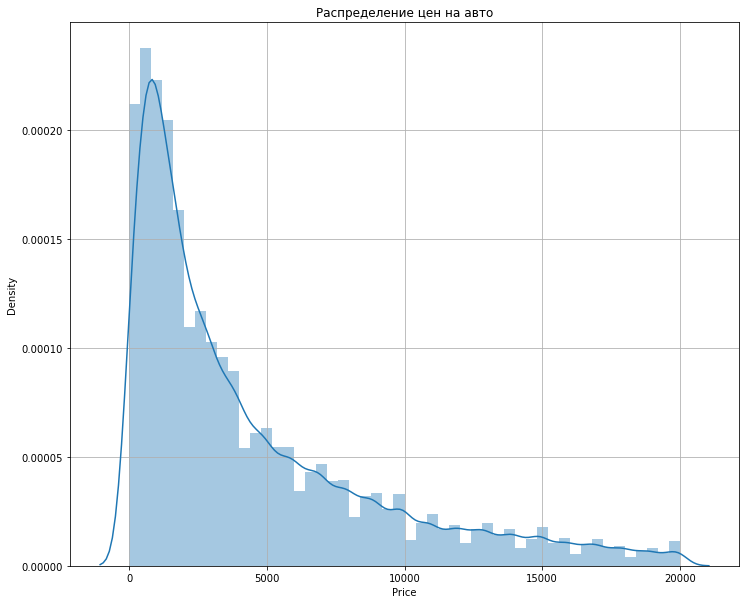

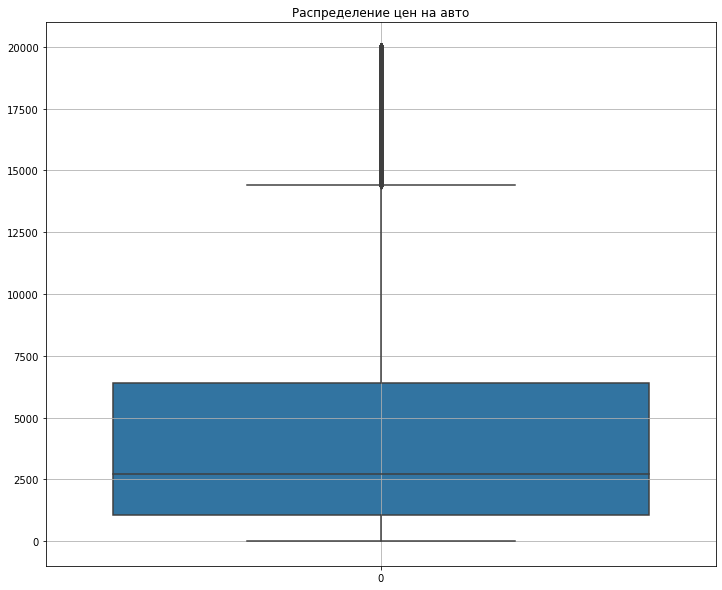

In [7]:
df_value_counts(autos, 'Price')
hist(autos, 'Price', 'Распределение цен на авто', 50)
boxplot(autos, 'Price', 'Распределение цен на авто')

*Пропусков в столбце нет, но есть маленькие и 0-ые значения. 0-ые значения скорее всего появились из-за того, что автор объявления хотел сделать что-то наподобие аукциона или потрговаться с ценой. Маленькие значения цены - скорее всего не цена самого авто, а какой либо детали от него, либо машина в неисправном состоянии. Если от 0 мы будем точно избавляться, дабы не ухудшать качество модели некачественными данными, то вот с маленькими значениями нужно будет понять где тот самый мининимум, ниже которого значения можно убирать.*

*Можно попробовать пойти сложным путем и сделать группировку по годам, после для каждого года выявить на тот год минимум, который считался бы "дном", ниже которого уже были бы выбросы. Либо указать некий мининум, который характеризовал бы цену для самой старой машины, возможно она еще была в авариях и что-то сломано, и относительно этой цены убрать из датасета значения поменьше*

In [8]:
# Пойдем легким путем :D
autos_v2 = autos.query('Price >= 500').reset_index(drop=True).copy()
print(autos_v2['Price'].min())
print(f'%: {autos_v2.shape[0]/autos.shape[0]:.1%}')

500
%: 89.8%


*Мы избавились от данных, которые были ниже 500 у.е.*

*Наш датасет сократился на 10.2%. Думаю работать дальше с таким кол-вом мы можем, поэтому идем дальше*

#### VehicleType

In [9]:
df_value_counts(autos_v2, 'VehicleType')

sedan          85475
small          68288
wagon          60739
bus            27835
convertible    19549
coupe          14842
suv            11715
other           2774
Name: VehicleType, dtype: int64
Кол-во пропусков в столбце: 27094


*Видим пропуски, скорее всего они связаны с тем, что авторы объявления не указывали тип кузова, либо данные были утеряны при переносе. Заполнить их можно самым часто встречающимся значением по марке и моделе автомобиля. Можно попробовать еще поиграться с годами, но пока что попробуем поработать так. Остальные данные, которые не получится заполнить пока чо отнесем к notdefined*

In [10]:
autos_v2['VehicleType'] = (
    autos_v2.groupby(['Brand', 'Model'])['VehicleType']
    .apply(lambda x: x.fillna(x.mode()[0])))
autos_v2['VehicleType'] = autos_v2['VehicleType'].fillna('notdefined')

df_value_counts(autos_v2, 'VehicleType')

sedan          92291
small          71955
wagon          61685
bus            30168
convertible    18986
notdefined     14681
coupe          14509
suv            11623
other           2413
Name: VehicleType, dtype: int64
Кол-во пропусков в столбце: 0


*Не все получилось заполнить (14 681 ушло как Not Defined)*

#### RegistrationYear and Age

In [11]:
df_value_counts(autos_v2, 'RegistrationYear')

2005    21055
2000    19872
2006    19614
1999    19553
2003    19248
        ...  
1949        1
1946        1
1931        1
1927        1
4100        1
Name: RegistrationYear, Length: 131, dtype: int64
Кол-во пропусков в столбце: 0


In [12]:
np.sort(autos_v2['RegistrationYear'].unique())

array([1000, 1001, 1039, 1234, 1400, 1500, 1600, 1602, 1800, 1910, 1923,
       1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
       1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2066, 2290, 2500, 2800, 2900, 3000,
       3200, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5911,
       6000, 7000, 7100, 7800, 8200, 8500, 8888, 9000, 9450, 9999],
      dtype=int64)

*Все, что выше 2016 янвно выбросы, мы от них избавимся, а вот касательно старых машин, то укажем машины после 1910 года, до этого значения идут выбросы*

In [13]:
autos_v2 = autos_v2.query('(RegistrationYear >= 1910) & (RegistrationYear <= 2016)').reset_index(drop=True)
df_value_counts(autos_v2, 'RegistrationYear')
print()
print(f'%: {autos_v2.shape[0]/autos.shape[0]:.1%}')

2005    21055
2000    19872
2006    19614
1999    19553
2003    19248
        ...  
1931        1
1946        1
1927        1
1925        1
1949        1
Name: RegistrationYear, Length: 92, dtype: int64
Кол-во пропусков в столбце: 0

%: 86.1%


*Убрали выбросы по годам. Осталось 86.1% от нашего изначального датасета, пока что работать дальше можно*

*Создадим новый признак Age, который будет содержать информацию о возрасте автомобиля на момент продажи*

In [14]:
autos_v2['Age'] = 2016 - autos_v2['RegistrationYear']

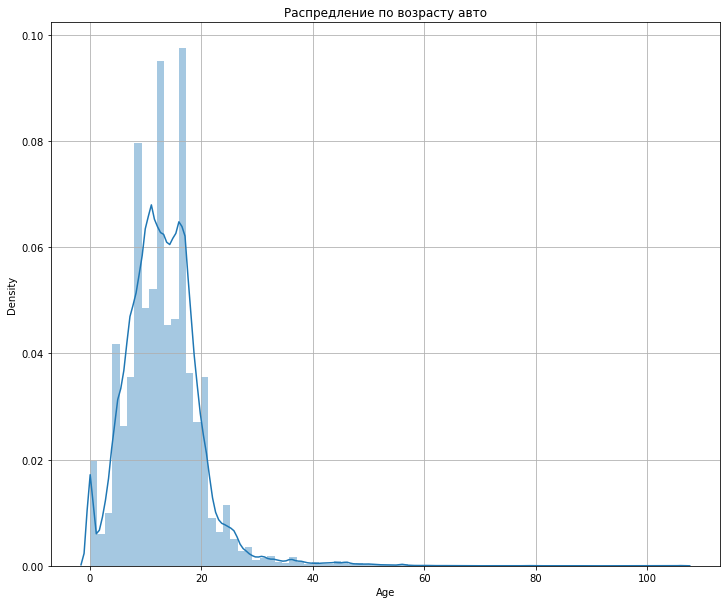

In [15]:
hist(autos_v2, 'Age', 'Распредление по возрасту авто', 80)

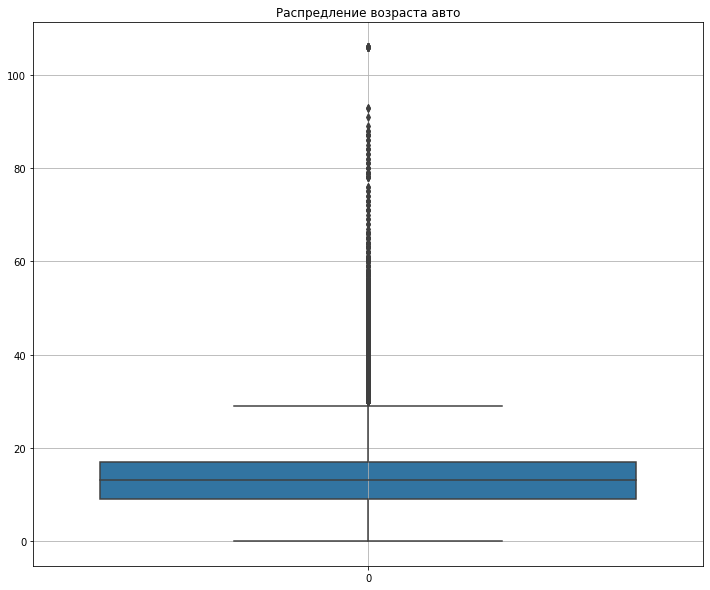

In [16]:
boxplot(autos_v2, 'Age', 'Распредление возраста авто')

*Распределение явно "шумное". Видне падение популярно после 18-20 лет, рынок также показывает, что чаще всего продают автомобили с возрастом в 10 лет, имеются также выбросы. Выбросы здесь - автомибили старше 29 лет, желательно эти данные убрать из датасета, после столбец "RegistrationYear" удалить*

In [17]:
autos_v2 = autos_v2.query('Age < 30').reset_index(drop=True)
autos_v2 = autos_v2.drop(['RegistrationYear'], axis=1)
print(f'%: {autos_v2.shape[0]/autos.shape[0]:.1%}')

%: 84.5%


#### Gearbox

In [18]:
df_value_counts(autos_v2, 'Gearbox')

manual    228149
auto       60349
Name: Gearbox, dtype: int64
Кол-во пропусков в столбце: 11038


*Gearbox является категориальным признаком, который необходиму будет в дальнейшем закодировать. Заполнить пропуски не представляется возможным, так как автомобил может иметь комплектацию как с ручной коробкой передач, так и с автоматической. Пока что заполним как Not Defined*

In [19]:
autos_v2['Gearbox'] = autos_v2['Gearbox'].fillna('notdefined')

#### Power

0        24164
75       19474
150      13377
140      12185
60       11897
         ...  
685          1
13636        1
1090         1
10311        1
6512         1
Name: Power, Length: 645, dtype: int64
Кол-во пропусков в столбце: 0


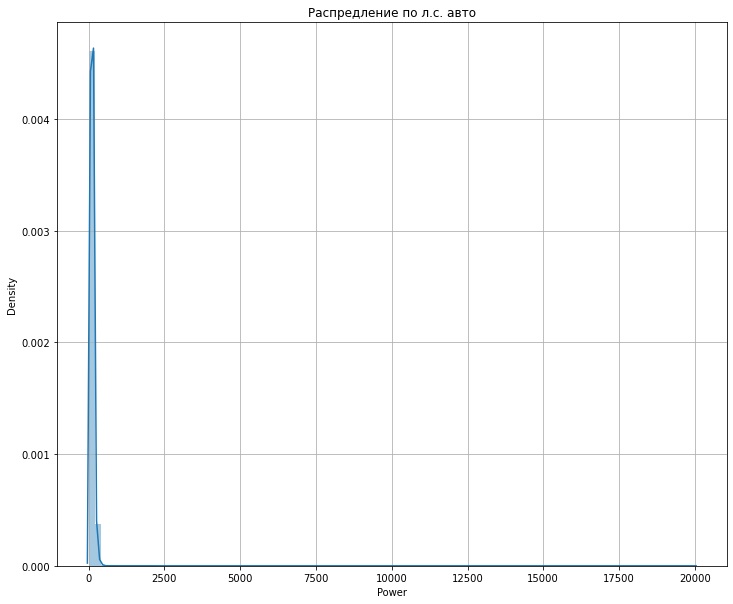

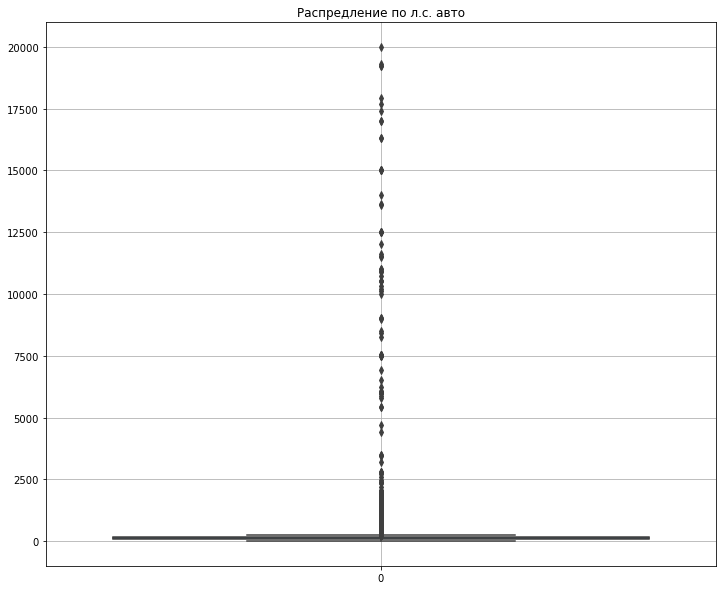

In [20]:
df_value_counts(autos_v2, 'Power')
hist(autos_v2, 'Power', 'Распредление по л.с. авто', 100)
boxplot(autos_v2, 'Power', 'Распредление по л.с. авто')

*Присутствуют выбросы и явно масштабные. Пропусков нет, но есть 0, заполним их средним значением относительно марки и модели*

In [21]:
autos_v2['Power'] = autos['Power'].replace(0, np.nan)
autos_v2['Power'] = autos_v2['Power'].fillna(autos_v2.groupby(['Brand', 'Model'])['Power'].transform('mean'))

In [22]:
autos_v2['Power'].describe()

count    298171.000000
mean        124.354256
std         192.532977
min           1.000000
25%          83.000000
50%         116.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

*Наврятли в этот список входят суперкары (на 2016 год вроде бы топом был буггати с 1500 лс), поэтому уберем значения свыше 500 л.с.. Касательно маленьких мощностей, то возьмем значения от 18 л.с.*

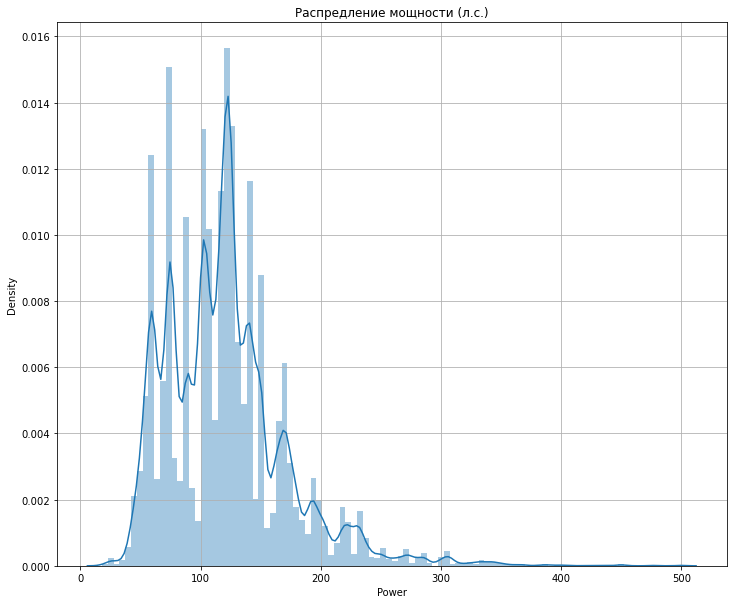

In [23]:
autos_v2 = autos_v2.query('(Power >= 18) & (Power <= 500)').reset_index(drop=True)
hist(autos_v2, 'Power', 'Распредление мощности (л.с.)', 100)

In [24]:
print(f'%: {autos_v2.shape[0]/autos.shape[0]:.1%}')

%: 83.9%


#### Model

In [25]:
df_value_counts(autos_v2, 'Model')

golf                  24398
other                 19168
3er                   17810
polo                  10013
corsa                  9302
                      ...  
i3                        6
samara                    5
elefantino                4
rangerover                3
range_rover_evoque        2
Name: Model, Length: 247, dtype: int64
Кол-во пропусков в столбце: 10502


*Колонка Model содержит данные о моделе автомобиля. Колонка содержит пропуски. Это категориальный признак, который необходимо будет закодировать перед обучением модели. Те модели, которые не удалось установить отнесем к типу not defined*

In [26]:
autos_v2['Model'] = autos_v2['Model'].fillna('notdefined')

#### Kilometer

150000    197595
125000     32068
100000     12744
90000      10337
80000       9008
70000       7780
60000       6832
50000       5641
40000       4508
30000       3870
20000       3272
5000        2938
10000        889
Name: Kilometer, dtype: int64
Кол-во пропусков в столбце: 0


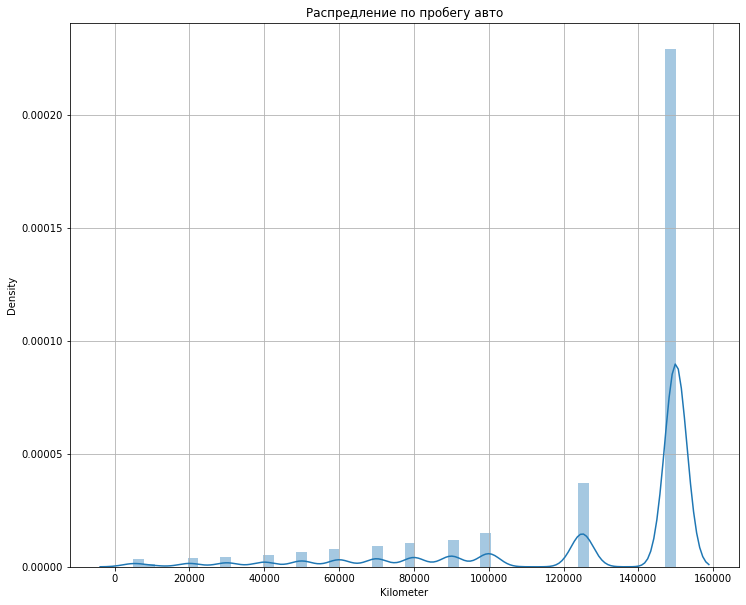

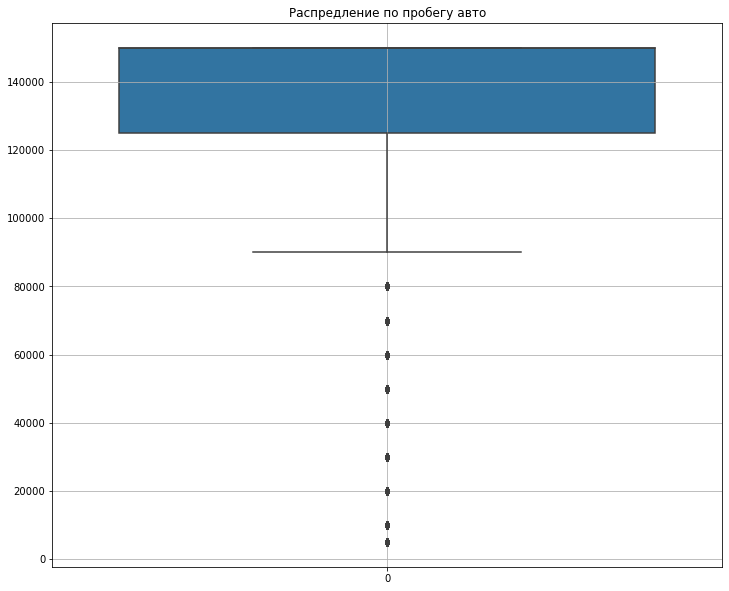

In [27]:
df_value_counts(autos_v2, 'Kilometer')
hist(autos_v2, 'Kilometer', 'Распредление по пробегу авто', 50)
boxplot(autos_v2, 'Kilometer', 'Распредление по пробегу авто')

*Пробегом может быть любым, макс значение похоже на правду, поэтому данные трогать не будем*

#### FuelType

In [28]:
df_value_counts(autos_v2, 'FuelType')

petrol      181895
gasoline     92844
lpg           4805
cng            503
hybrid         215
other           88
electric        77
Name: FuelType, dtype: int64
Кол-во пропусков в столбце: 17055


*FuelType является категориальным признаком, который необходиму будет в дальнейшем закодировать. Заполнить пропуски  относительно марки и модели, а оставшиеся значения заполним как Not Defined*

In [29]:
autos_v2['VehicleType'] = (
    autos_v2.groupby(['Brand', 'Model'])['FuelType']
    .apply(lambda x: x.fillna(x.mode()[0])))
autos_v2['FuelType'] = autos_v2['FuelType'].fillna('notdefined')

df_value_counts(autos_v2, 'FuelType')

petrol        181895
gasoline       92844
notdefined     17055
lpg             4805
cng              503
hybrid           215
other             88
electric          77
Name: FuelType, dtype: int64
Кол-во пропусков в столбце: 0


*Не получилось распределить относительно модели и марки ((((*

#### Brand

In [30]:
df_value_counts(autos_v2, 'Brand')

volkswagen        64058
bmw               33151
opel              31226
mercedes_benz     28699
audi              26421
ford              19774
renault           13941
peugeot            9506
fiat               7385
seat               5784
skoda              5132
smart              4865
mazda              4738
citroen            4299
toyota             4272
nissan             4118
hyundai            3243
mini               3008
volvo              2761
mitsubishi         2440
honda              2395
kia                2213
suzuki             1978
alfa_romeo         1898
sonstige_autos     1494
chevrolet          1461
chrysler           1207
dacia               860
subaru              616
jeep                586
daihatsu            584
porsche             544
land_rover          487
saab                464
jaguar              447
daewoo              390
rover               337
lancia              330
trabant             199
lada                171
Name: Brand, dtype: int64
Кол-во пропуск

*Колонка Brand содержит данные о бренде автомобиля. Это категориальный признак, который необходимо будет закодировать перед обучением модели. Колонка не содержит пропусков*

#### NotRepaired

In [31]:
df_value_counts(autos_v2, 'NotRepaired')

no     225882
yes     24839
Name: NotRepaired, dtype: int64
Кол-во пропусков в столбце: 46761


*Пропуски заполним как Not Defined*

In [32]:
autos_v2['NotRepaired'] = autos_v2['NotRepaired'].fillna('notdefined')

#### NumberOfPictures

In [33]:
df_value_counts(autos_v2, 'NumberOfPictures')

0    297482
Name: NumberOfPictures, dtype: int64
Кол-во пропусков в столбце: 0


*Колонка VehicleType содержит данные о количестве фотографий автомобиля. У всех автомобилей отсутствуют фотографии. Эта колонка также не повлияет на модель, удалим ее из датасета.*

In [34]:
autos_v2 = autos_v2.drop(['NumberOfPictures'], axis = 1)

### Выделим обучающую и валидационную выборки

In [35]:
autos_train, autos_valid = train_test_split(autos_v2, test_size = .25, random_state = 12345)

In [36]:
autos_train_cb = autos_train.copy()
autos_valid_cb = autos_valid.copy()

### Закодируем категориальные признаки и масштабируем количественные

*Преобразованные данные содержат категориальные признаки VehicleType, Gearbox, Model, FuelType, Brand, NotRepaired, которые необходимо закодировать для дальнейшего обучения модели. Для этого используем метод кодирования OrdinalEncoder на данных, у которых больше 3 категорий и One-Hot Encoding на данных, у которых не болee 3-х категорий.*

In [37]:
category_oe = ['VehicleType','Model', 'FuelType', 'Brand']
category_ohe = ['Gearbox', 'NotRepaired']
encoder = OrdinalEncoder()
encoder.fit(autos_v2[category_oe])

# закодируем обучающую выборку
autos_train[category_oe] = encoder.transform(autos_train[category_oe])
autos_train = pd.get_dummies(autos_train, columns = category_ohe, drop_first = True)

# закодируем тестовую выборку
autos_valid[category_oe] = encoder.transform(autos_valid[category_oe])
autos_valid = pd.get_dummies(autos_valid, columns = category_ohe, drop_first = True)

*В данных присутствуют колличественные признаки с разными разбросами значений. Для того, чтобы алгоритм не решил, что признаки с большими значениями и разбросом важнее, маcштабируем количественные признаки*

In [38]:
numeric = ['Kilometer','Age', 'Power']
scaler = MinMaxScaler()
scaler.fit(autos_train[numeric])

# масштабируем обучающую выборку
autos_train[numeric] = scaler.transform(autos_train[numeric])
autos_train_cb[numeric] = scaler.transform(autos_train_cb[numeric])

# масштабируем тестовую выборку
autos_valid[numeric] = scaler.transform(autos_valid[numeric])
autos_valid_cb[numeric] = scaler.transform(autos_valid_cb[numeric])

# Вывод

*Провели предобработку данных. Заполнени пропуски, удалили выбросы. Категориальные данные были закодированы, а количественные масштабированы. Разделили выборку на обучающую и валидационную*

# 2. Обучение моделей

### Разделим выборки на признаки и целевые признаки

In [39]:
# Обучающая выборка
features_train = autos_train.drop(['Price'], axis=1)
features_train_cb = autos_train_cb.drop(['Price'], axis=1)
target_train = autos_train['Price']


# Валидационная
features_valid = autos_valid.drop(['Price'], axis=1)
features_valid_cb = autos_valid_cb.drop(['Price'], axis=1)
target_valid = autos_valid['Price']

In [40]:
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_train.columns).sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(12,6))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

### Линейная регрессия

In [41]:
def lr_gridsearchcv(features, target):    
    model = LinearRegression()
    param_grid = {
        'copy_X': [True, False],
        'fit_intercept' : [True, False],
        'normalize': [True, False]
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv=5, scoring = 'neg_mean_squared_error')
    CV.fit(features, target)
    
    print('Лучшее значение метрики RMSE: {:.2f}'.format((-CV.best_score_) ** .5))
    print('Лучшие гиперпараметры: ', CV.best_params_)
    return CV.best_params_, -CV.best_score_

In [42]:
%%time
best_params_lr, rmse_lr_result = lr_gridsearchcv(features_train, target_train)

Лучшее значение метрики RMSE: 3266.59
Лучшие гиперпараметры:  {'copy_X': True, 'fit_intercept': True, 'normalize': True}
Wall time: 20.4 s


*Гипперпараметры подобраны, лучшее значение RMSE 3266.59, подбор выполнен за 10.6 сек.*

### CatBoost

In [43]:
cat_col = ['VehicleType','Model', 'FuelType', 'Brand', 'Gearbox', 'NotRepaired']

In [44]:
features_train_cb[cat_col] = features_train_cb[cat_col].astype('category')

In [45]:
def catboost_gridsearchcv(features, target, cat_features=None):
    model = CatBoostRegressor(cat_features=cat_features)
    param_grid = {
        'n_estimators': [500],
        'learning_rate': [0.1, 0.15],
        'depth': np.arange(4, 10),
        'random_state': [42],
        'boosting_type': ['Plain']
    }
    CV = model.grid_search(param_grid, 
                           X=features, 
                           y=target, 
                           cv=5)
    print('Лучшее значение метрики RMSE: {:.2f}'.format(model.get_best_score()['learn']['RMSE']))
    print('Лучшие гиперпараметры: ', CV['params'])
    return  CV['params'], model.get_best_score()['learn']['RMSE']

In [46]:
%%time
best_param_catboost_cat, rmse_cb_result_cat = catboost_gridsearchcv(features_train_cb, target_train, cat_col)


bestTest = 2010.196977
bestIteration = 499

0:	loss: 2010.1969767	best: 2010.1969767 (0)	total: 50.4s	remaining: 9m 14s

bestTest = 1980.434565
bestIteration = 499

1:	loss: 1980.4345653	best: 1980.4345653 (1)	total: 1m 41s	remaining: 8m 25s

bestTest = 1964.785128
bestIteration = 499

2:	loss: 1964.7851277	best: 1964.7851277 (2)	total: 2m 44s	remaining: 8m 13s

bestTest = 1945.24373
bestIteration = 499

3:	loss: 1945.2437302	best: 1945.2437302 (3)	total: 3m 44s	remaining: 7m 28s

bestTest = 1934.195993
bestIteration = 499

4:	loss: 1934.1959925	best: 1934.1959925 (4)	total: 4m 53s	remaining: 6m 51s

bestTest = 1914.997568
bestIteration = 499

5:	loss: 1914.9975682	best: 1914.9975682 (5)	total: 6m 3s	remaining: 6m 3s

bestTest = 1907.925732
bestIteration = 499

6:	loss: 1907.9257319	best: 1907.9257319 (6)	total: 7m 25s	remaining: 5m 18s

bestTest = 1890.79535
bestIteration = 499

7:	loss: 1890.7953501	best: 1890.7953501 (7)	total: 8m 49s	remaining: 4m 24s

bestTest = 1891.112672
bestI

In [47]:
%%time
best_param_catboost, rmse_cb_result = catboost_gridsearchcv(features_train, target_train)


bestTest = 2073.996392
bestIteration = 499

0:	loss: 2073.9963924	best: 2073.9963924 (0)	total: 9.76s	remaining: 1m 47s

bestTest = 2007.637048
bestIteration = 499

1:	loss: 2007.6370481	best: 2007.6370481 (1)	total: 19.6s	remaining: 1m 37s

bestTest = 2016.104448
bestIteration = 499

2:	loss: 2016.1044478	best: 2007.6370481 (1)	total: 30.9s	remaining: 1m 32s

bestTest = 1958.783375
bestIteration = 499

3:	loss: 1958.7833749	best: 1958.7833749 (3)	total: 42.5s	remaining: 1m 24s

bestTest = 1963.997897
bestIteration = 499

4:	loss: 1963.9978968	best: 1958.7833749 (3)	total: 55.7s	remaining: 1m 17s

bestTest = 1917.914958
bestIteration = 499

5:	loss: 1917.9149585	best: 1917.9149585 (5)	total: 1m 8s	remaining: 1m 8s

bestTest = 1927.220652
bestIteration = 499

6:	loss: 1927.2206519	best: 1917.9149585 (5)	total: 1m 23s	remaining: 59.8s

bestTest = 1892.160368
bestIteration = 499

7:	loss: 1892.1603684	best: 1892.1603684 (7)	total: 1m 38s	remaining: 49.2s

bestTest = 1904.131466
bestItera

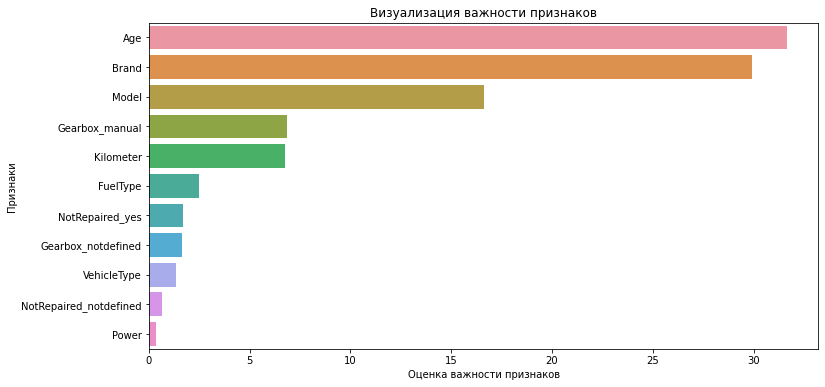

In [48]:
model_cb = CatBoostRegressor(**best_param_catboost)
model_cb.fit(features_train, target_train, verbose=0)
chart_feature_imp(model_cb)

*Гипперпараметры подобраны. Можно наблюдать, что ручная кодировка эффективнее (время) справляется, чем указание категориальных признаков в самом кэтбусте. Время на обучение составило 4 мин 3 сек*

### LightGBM

In [49]:
def lgbm_gridsearchcv(features, target):
    model = lgb.LGBMRegressor()
    param_grid = {
        'n_jobs': [-1],
        'boosting_type': ['gbdt'],
        'objective': ['regression'],
        'metric': ['rmse'],
        'n_estimators': [500],
        'max_depth': np.arange(4, 10),
        'learning_rate': [0.1, 0.15],
        'random_state': [42],
    }
    CV = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring = 'neg_mean_squared_error')
    CV.fit(features, target)
    print('Лучшее значение метрики RMSE: {:.2f}'.format((-CV.best_score_) ** .5))
    print('Лучшие гиперпараметры: ', CV.best_params_)
    return CV.best_params_, -CV.best_score_

In [50]:
%%time
best_param_lgbmregressor, rmse_lgbm_result = lgbm_gridsearchcv(features_train, target_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

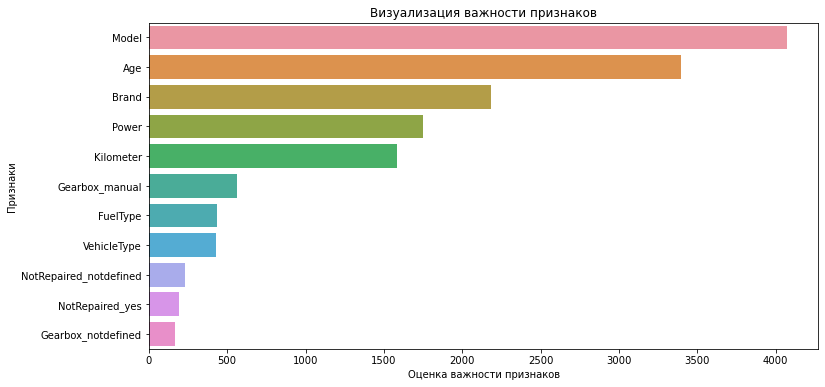

In [51]:
model_lgb = lgb.LGBMRegressor(**best_param_lgbmregressor)
model_lgb.fit(features_train, target_train, verbose=0)
chart_feature_imp(model_lgb)

*Гипперпарамеиры подобраны, лучшее значение метрики 1853.44, подбор проходит за 1 мин 37 сек.*

## Вывод

*Провели кросс-валидацию обучающей выборки и подобрали для каждой модели лучшие гипперпараметры. Самые хорошие показатели метрики на обучающей выборке показала модель ЛГБМ, Кэтбуст не сильно отстал, В плане обучения, то Кэтбуст явно оказался быстрее ЛГБМ. Линейная регресия хоть и посчитала все быстро, но показатель метрики RMSE явно желает лучшего.*

# 3. Анализ моделей

## Проанализируем обученные модели на тестовой выборке

### Линейная регрессия

In [59]:
%%time
model_lr = LinearRegression(**best_params_lr)
model_lr.fit(features_train, target_train)
predictions_lr = model_lr.predict(features_valid)
rmse_lr = mean_squared_error(predictions_lr, target_valid) ** .5
print('RMSE:', rmse_lr)

RMSE: 3278.48935099325
Wall time: 67 ms


*Линейная регрессия показала себя плохо как на обучающей выборке, так и на валидационной*

### CatBoost

In [55]:
%%time
model_cb = CatBoostRegressor(**best_param_catboost)
model_cb.fit(features_train, target_train)
predictions_cb = model_cb.predict(features_valid)
rmse_cb = mean_squared_error(predictions_cb, target_valid) ** .5
print('RMSE:', rmse_cb)

0:	learn: 4126.7447152	total: 32.3ms	remaining: 16.1s
1:	learn: 3796.2282905	total: 59.4ms	remaining: 14.8s
2:	learn: 3530.8318579	total: 89.9ms	remaining: 14.9s
3:	learn: 3319.2543500	total: 119ms	remaining: 14.8s
4:	learn: 3131.7815282	total: 145ms	remaining: 14.3s
5:	learn: 2984.5942812	total: 172ms	remaining: 14.2s
6:	learn: 2865.0732186	total: 203ms	remaining: 14.3s
7:	learn: 2775.3197888	total: 231ms	remaining: 14.2s
8:	learn: 2696.3804194	total: 261ms	remaining: 14.3s
9:	learn: 2629.1504403	total: 291ms	remaining: 14.2s
10:	learn: 2577.8553612	total: 320ms	remaining: 14.2s
11:	learn: 2532.8104449	total: 348ms	remaining: 14.2s
12:	learn: 2500.2289275	total: 376ms	remaining: 14.1s
13:	learn: 2466.6698197	total: 403ms	remaining: 14s
14:	learn: 2434.4896248	total: 432ms	remaining: 14s
15:	learn: 2410.5984754	total: 460ms	remaining: 13.9s
16:	learn: 2384.4553095	total: 488ms	remaining: 13.9s
17:	learn: 2366.0903460	total: 517ms	remaining: 13.8s
18:	learn: 2353.0924964	total: 541ms	re

*Показатель метрики RMSE чуть упал. Значительно сократилось время, так как мы уже не перебирали гипперпараметры, а взяли лучшие*

### LightGBM

In [56]:
%%time
model_lgb = lgb.LGBMRegressor(**best_param_lgbmregressor)
model_lgb.fit(features_train, target_train)
predictions_lgb = model_lgb.predict(features_valid)
rmse_lgbm = mean_squared_error(predictions_lgb, target_valid)**.5
print('RMSE:', rmse_lgbm)

RMSE: 1846.4896822507146
Wall time: 1.96 s


*ЛГБМ на валидационной выборке показал себя получше, чем на обучающей.*

### Dummy

In [57]:
mean = target_train.mean()
len = features_valid.shape[0]
dummy_predictions = np.full((len, 1), mean)
dummy_rmse = mean_squared_error(dummy_predictions, target_valid)**0.5
print('RMSE (константная модель):',dummy_rmse)

RMSE (константная модель): 4544.446567523317


## Вывод

*LGBM показала лучшие результаты*

*Обучение LGBMt было быстрее, чем у CatBoost, а результаты CatBoost по метрике RMSE были чуть лучше. Так как модели показали себя +/- одинаково по показателям метрики RMSE, будем смотреть на времязатратность на обучение, и тут LGBM явный фаворит*

## Итог

In [62]:
d = {'RMSE': [rmse_lr, rmse_cb, rmse_lgbm],'RMSE(mean)' : [dummy_rmse, dummy_rmse, dummy_rmse]}
final = pd.DataFrame(data=d, index = ['Линейная регрессия', 'CatBoostRegressor', 'LGBMRegressor'])
display(final)

,RMSE,RMSE(mean)
Линейная регрессия,3278.489351,4544.446568
CatBoostRegressor,1853.536656,4544.446568
LGBMRegressor,1846.489682,4544.446568


## Вывод

*Данные проанализированы, а также обработаны (пропуски заполнены, нулевые значения изменены, выбросы и дубликаты удалены). Категориальные признаки закодированы, а количественные масштабированы. Использовали 3 модели (Линейная регрессия, CatBoost, LightGBM. Лучше всех себя показал CatBoost и LGBM*